In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import scale
from sklearn.svm import SVR

seasons = range(1993, 2023+1)

dfs = []
for season in seasons:
    df = pd.read_csv(f'data/player_mvps_{season}.csv')
    df = df.drop(labels=['Tm'], axis=1)

    adv_df = pd.read_csv(f'data/player_advanced_{season}.csv')
    adv_df = adv_df.drop(labels=['Tm', 'Age', 'WS', 'WS/48', 'G', 'MP'], axis=1)

    df = df.merge(adv_df, how='inner', on='Player')
    df['Won'] = df.index == 0
    dfs.append(df)
dfs[0].head()

,Player,Age,First,Pts Won,Pts Max,Share,G,MP,PTS,TRB,...,BLK%,TOV%,USG%,OWS,DWS,OBPM,DBPM,BPM,VORP,Won
0,Charles Barkley,29,59.0,835.0,980,0.852,76,37.6,25.6,12.2,...,1.6,12.5,26.9,9.6,4.8,6.3,1.4,7.8,7.1,True
1,Hakeem Olajuwon,30,22.0,647.0,980,0.660,82,39.5,26.1,13.0,...,6.5,12.4,28.8,7.9,8.0,3.9,3.6,7.5,7.8,False
2,Michael Jordan,29,13.0,565.0,980,0.577,78,39.3,32.6,6.7,...,1.3,8.4,34.7,12.0,5.2,8.7,2.6,11.2,10.2,False
3,Patrick Ewing,30,4.0,359.0,980,0.366,81,37.1,24.2,12.1,...,3.6,12.9,29.7,2.6,8.1,1.4,2.0,3.4,4.0,False
4,Dominique Wilkins,33,0.0,54.0,980,0.055,71,37.3,29.9,6.8,...,0.6,9.0,31.9,9.1,1.4,7.1,-1.7,5.4,4.9,False


In [2]:
df = pd.concat(dfs).reset_index(drop=True)
df.head()

,Player,Age,First,Pts Won,Pts Max,Share,G,MP,PTS,TRB,...,BLK%,TOV%,USG%,OWS,DWS,OBPM,DBPM,BPM,VORP,Won
0,Charles Barkley,29,59.0,835.0,980,0.852,76,37.6,25.6,12.2,...,1.6,12.5,26.9,9.6,4.8,6.3,1.4,7.8,7.1,True
1,Hakeem Olajuwon,30,22.0,647.0,980,0.660,82,39.5,26.1,13.0,...,6.5,12.4,28.8,7.9,8.0,3.9,3.6,7.5,7.8,False
2,Michael Jordan,29,13.0,565.0,980,0.577,78,39.3,32.6,6.7,...,1.3,8.4,34.7,12.0,5.2,8.7,2.6,11.2,10.2,False
3,Patrick Ewing,30,4.0,359.0,980,0.366,81,37.1,24.2,12.1,...,3.6,12.9,29.7,2.6,8.1,1.4,2.0,3.4,4.0,False
4,Dominique Wilkins,33,0.0,54.0,980,0.055,71,37.3,29.9,6.8,...,0.6,9.0,31.9,9.1,1.4,7.1,-1.7,5.4,4.9,False


In [3]:
df = df.drop(labels=['Player', 'Pos'], axis=1)

In [4]:
df.isna().any()

Age        False
First      False
Pts Won    False
Pts Max    False
Share      False
G          False
MP         False
PTS        False
TRB        False
AST        False
STL        False
BLK        False
FG%        False
3P%         True
FT%        False
WS         False
WS/48      False
PER        False
TS%        False
3PAr       False
FTr        False
ORB%       False
DRB%       False
TRB%       False
AST%       False
STL%       False
BLK%       False
TOV%       False
USG%       False
OWS        False
DWS        False
OBPM       False
DBPM       False
BPM        False
VORP       False
Won        False
dtype: bool

In [5]:
df.replace(np.NaN, 0, inplace=True)

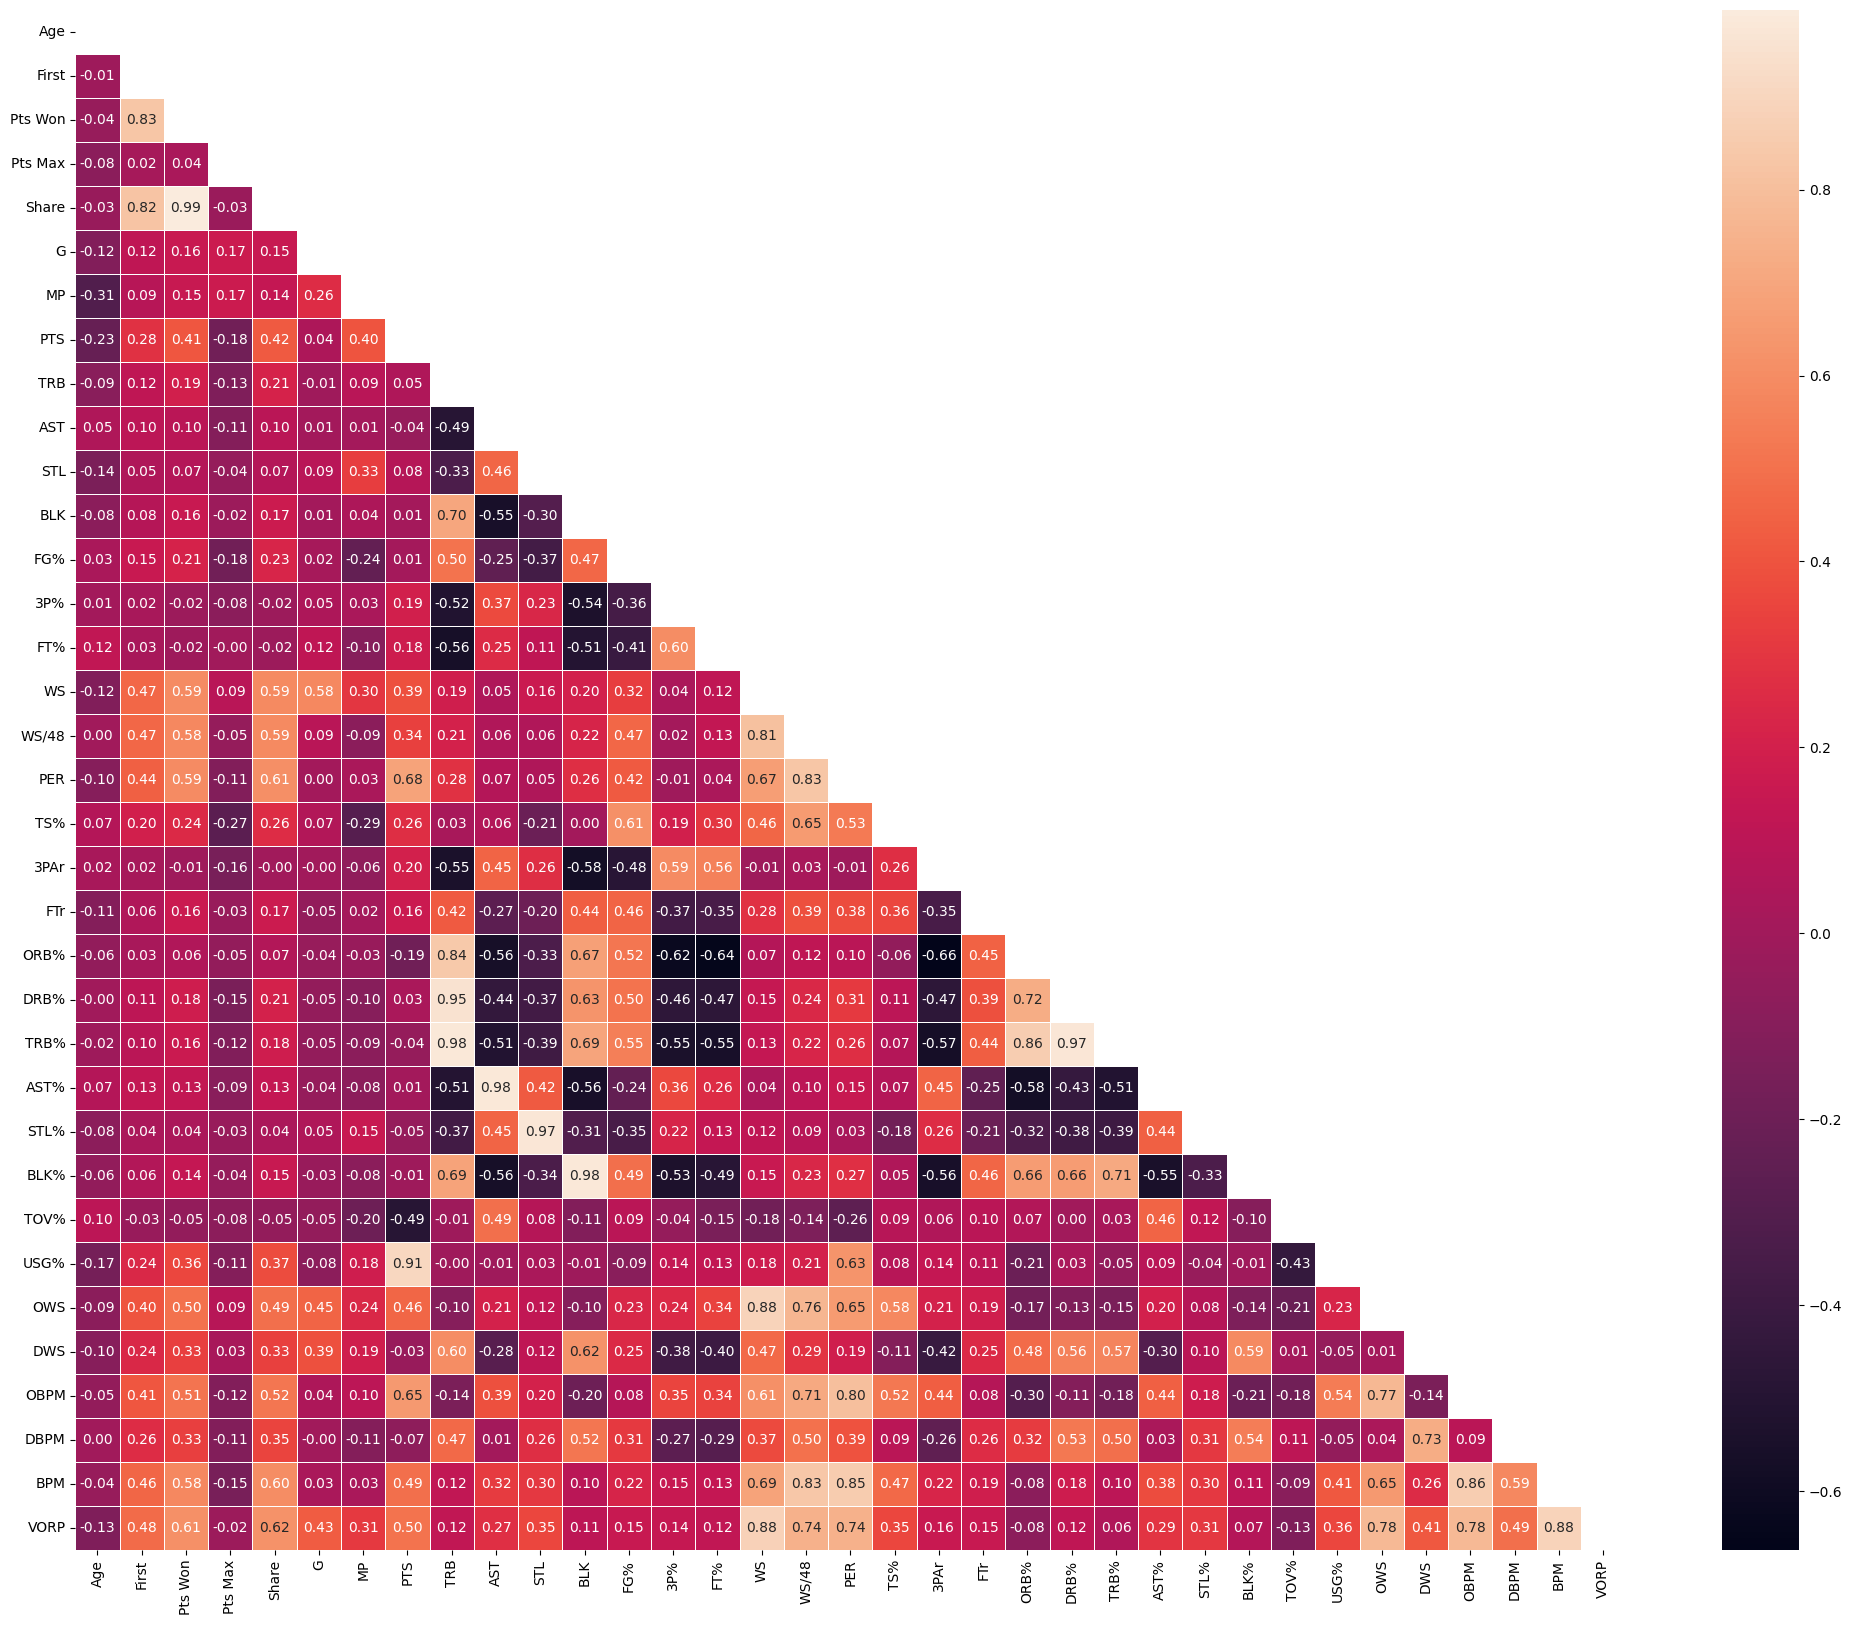

In [6]:
df_view = df[df.columns[:-1]]
corr = df_view.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(25,20), edgecolor="#04253a")
sns.heatmap(corr, annot=True, mask=mask, linewidths=.5, fmt=".2f")
plt.savefig('assets/images/corr-matrix.png')
plt.show()

In [7]:
stats = ['PTS', 'WS', 'WS/48', 'PER', 'TS%', 'USG%', 'OWS', 'DWS', 'OBPM', 'DBPM', 'BPM', 'VORP']

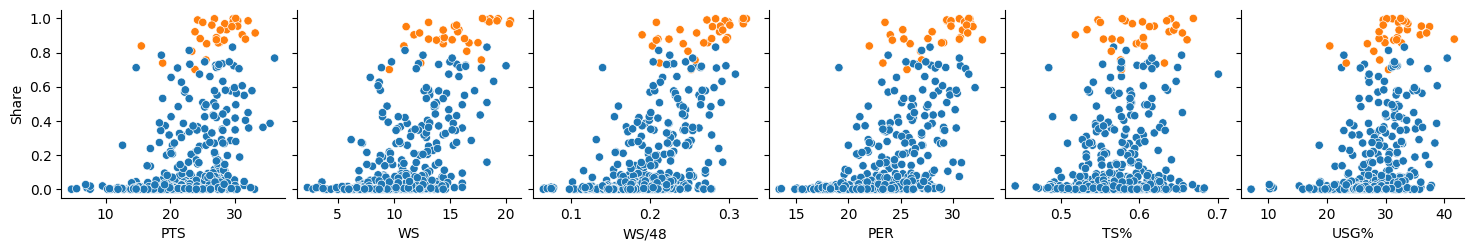

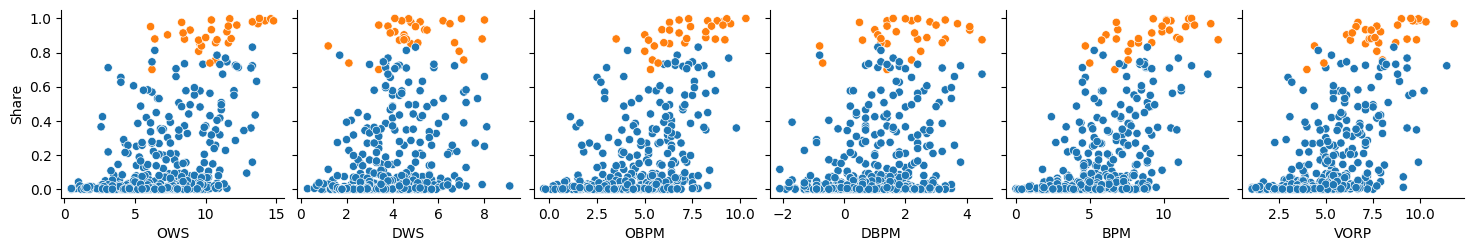

In [8]:
columns = df.columns.tolist()
sns.pairplot(df, x_vars=stats[:6], y_vars=['Share'], hue='Won')._legend.remove()
plt.savefig('assets/images/scatters-1.png')
sns.pairplot(df, x_vars=stats[6:], y_vars=['Share'], hue='Won')._legend.remove()
plt.savefig('assets/images/scatters-2.png')
plt.show()

In [9]:
X = df[stats].to_numpy()
X.shape

(462, 12)

In [10]:
y = df['Share'].to_numpy()
y.shape

(462,)

In [11]:
X = scale(X)
X

array([[ 0.57207554,  1.09736228,  0.97627999, ...,  0.32582557,
         0.89949827,  1.06205372],
       [ 0.66770434,  1.52082981,  0.80668369, ...,  2.02849453,
         0.78155081,  1.41746367],
       [ 1.91087884,  1.94429734,  1.56986704, ...,  1.25455409,
         2.2362361 ,  2.63601206],
       ...,
       [ 0.45732097, -1.01997536, -1.05887559, ..., -1.45423743,
        -1.18424011, -1.17195166],
       [ 0.26606335, -0.62675551, -0.44408901, ..., -1.14466125,
        -0.63381865, -0.76576887],
       [ 0.6868301 , -1.44344288, -1.01647652, ..., -0.37072082,
         0.07386608, -0.61345032]])

In [12]:
models = []
lr = LinearRegression()
lr.fit(X, y)
models.append(lr)

In [13]:
rfr = RandomForestRegressor(n_estimators=100, random_state=42)
rfr.fit(X, y)
models.append(rfr)

In [14]:
svr = SVR(epsilon=0.01)
svr.fit(X, y)
models.append(svr)

In [15]:
mlp = MLPRegressor(random_state=42, max_iter=1000)
mlp.fit(X, y)
models.append(mlp)

In [16]:
r1 = LinearRegression()
r2 = RandomForestRegressor(n_estimators=100, random_state=42)
r3 = KNeighborsRegressor()

er1 = VotingRegressor([('lr', r1), ('rf', r2), ('r3', r3)])
er1.fit(X, y)
models.append(er1)

In [17]:
reg1 = GradientBoostingRegressor(random_state=42)
reg2 = RandomForestRegressor(n_estimators=100, random_state=42)
reg3 = LinearRegression()

er2 = VotingRegressor(estimators=[('gb', reg1), ('rf', reg2), ('lr', reg3)])
er2.fit(X, y)
models.append(er2)

In [18]:
def acc(model, dfs):
    correct = 0
    for df in dfs:
        X = df[stats].replace(np.NaN, 0).to_numpy()
        X = scale(X)
        if np.argmax(model.predict(X)) == 0:
            correct += 1
    return correct / len(dfs)

In [19]:
scores = []
accs = []
for model in models:
    scores.append(model.score(X, y))
    accs.append(acc(model, dfs))
accs, scores

([0.6451612903225806,
  0.6129032258064516,
  0.7096774193548387,
  0.6451612903225806,
  0.6129032258064516,
  0.6129032258064516],
 [0.4792558660094782,
  0.9356455680253357,
  0.6631698292395414,
  0.7025817265767036,
  0.7594567149558111,
  0.8333591789626081])

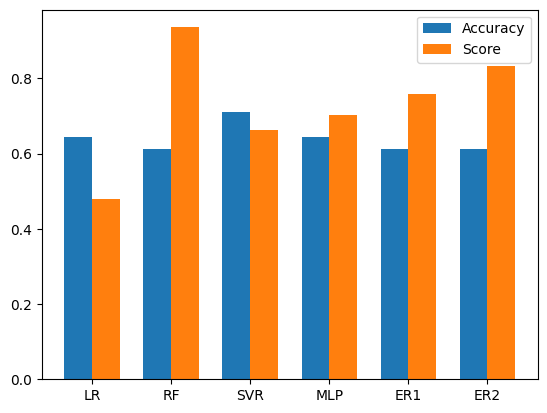

In [20]:
model_names = ['LR', 'RF', 'SVR', 'MLP', 'ER1', 'ER2']
bar_width = 0.35
index = np.arange(len(model_names))

plt.bar(index, accs, width=bar_width, label='Accuracy')
plt.bar(index + bar_width, scores, width=bar_width, label='Score')

plt.xticks(index + bar_width / 2, model_names)
plt.legend()
plt.savefig('assets/images/scores.png')
plt.show()

In [84]:
preds = []
for model in models:
    df_2023 = dfs[-1]
    X = df_2023[stats].replace(np.NaN, 0).to_numpy()
    X = scale(X)
    preds.append(np.minimum(1., np.maximum(0., model.predict(X))))

In [85]:
df_2023.head()

,Player,Age,First,Pts Won,Pts Max,Share,G,MP,PTS,TRB,...,BLK%,TOV%,USG%,OWS,DWS,OBPM,DBPM,BPM,VORP,Won
0,Joel Embiid,28,73.0,915.0,1000,0.915,66,34.6,33.1,10.2,...,4.6,11.9,37.0,8.4,3.9,6.8,2.3,9.2,6.4,True
1,Nikola Jokić,27,15.0,674.0,1000,0.674,69,33.7,24.5,11.8,...,1.8,17.0,27.2,11.2,3.8,8.5,4.5,13.0,8.8,False
2,Giannis Antetokounmpo,28,12.0,606.0,1000,0.606,63,32.1,31.1,11.8,...,2.1,13.2,38.8,4.9,3.7,5.8,2.7,8.5,5.4,False
3,Jayson Tatum,24,0.0,280.0,1000,0.280,74,36.9,30.1,8.8,...,1.6,10.4,32.7,6.2,4.3,4.8,0.7,5.5,5.1,False
4,Shai Gilgeous-Alexander,24,0.0,46.0,1000,0.046,68,35.5,31.4,4.8,...,2.5,10.1,32.8,8.4,3.0,5.7,1.5,7.3,5.6,False


In [86]:
preds

[array([0.3953511 , 0.31406761, 0.32525669, 0.31937983, 0.26198003,
        0.17972425, 0.1869637 , 0.13496539, 0.        , 0.19798622,
        0.02082703, 0.00711685, 0.07732415]),
 array([0.51647, 0.46443, 0.18895, 0.13368, 0.16258, 0.03371, 0.12797,
        0.28428, 0.025  , 0.13189, 0.00674, 0.01399, 0.01012]),
 array([0.66296781, 0.64990393, 0.20530612, 0.14926778, 0.10196593,
        0.01920886, 0.        , 0.11013667, 0.        , 0.0177955 ,
        0.0196477 , 0.01796873, 0.        ]),
 array([0.62860441, 0.55956404, 0.37486313, 0.23728245, 0.07681543,
        0.02349934, 0.        , 0.19716555, 0.        , 0.12406156,
        0.16113538, 0.15873556, 0.03302937]),
 array([0.43654037, 0.49296587, 0.20033556, 0.17175328, 0.26652001,
        0.11014475, 0.10591123, 0.26001513, 0.        , 0.14029207,
        0.01058901, 0.00743562, 0.03234805]),
 array([0.48045123, 0.42971613, 0.29316676, 0.19475208, 0.19145032,
        0.07792202, 0.1208858 , 0.21027273, 0.        , 0.13843944,
 

In [87]:
names = [n for n in df_2023['Player']]

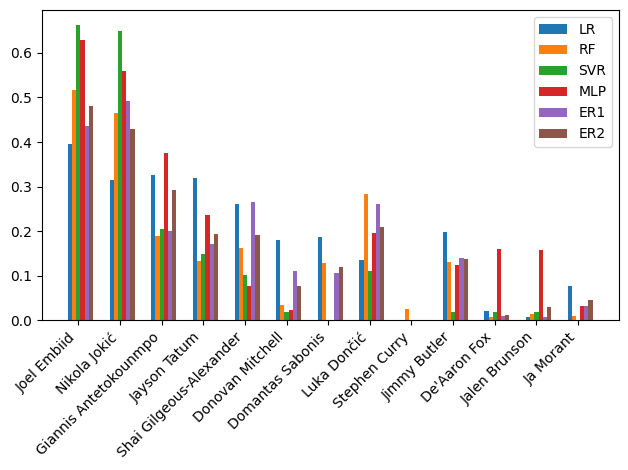

In [88]:
index = np.arange(len(names))
bar_width = 0.1
plt.bar(index, preds[0], width=bar_width, label='LR')
plt.bar(index + bar_width, preds[1], width=bar_width, label='RF')
plt.bar(index + bar_width*2, preds[2], width=bar_width, label='SVR')
plt.bar(index + bar_width*3, preds[3], width=bar_width, label='MLP')
plt.bar(index + bar_width*4, preds[4], width=bar_width, label='ER1')
plt.bar(index + bar_width*5, preds[5], width=bar_width, label='ER2')

plt.xticks(index + 2*bar_width, names, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.savefig('assets/images/mvp-race-2023.png')
plt.show()

In [73]:
preds_2016 = []
for model in models:
    df_2016 = dfs[-8]
    X = df_2016[stats].replace(np.NaN, 0).to_numpy()
    X = scale(X)
    preds_2016.append(np.minimum(1., np.maximum(0., model.predict(X))))
df_2016.head()

,Player,Age,First,Pts Won,Pts Max,Share,G,MP,PTS,TRB,...,BLK%,TOV%,USG%,OWS,DWS,OBPM,DBPM,BPM,VORP,Won
0,Stephen Curry,27,131.0,1310.0,1310,1.000,79,34.2,30.1,5.4,...,0.4,12.9,32.6,13.8,4.1,10.3,1.6,11.9,9.5,True
1,Kawhi Leonard,24,0.0,634.0,1310,0.484,72,33.1,21.2,6.8,...,2.3,7.8,25.8,8.3,5.5,6.1,3.0,9.1,6.7,False
2,LeBron James,31,0.0,631.0,1310,0.482,76,35.6,25.3,7.4,...,1.5,13.2,31.4,9.6,4.0,7.0,2.0,9.0,7.5,False
3,Russell Westbrook,27,0.0,486.0,1310,0.371,80,34.4,23.5,7.8,...,0.6,16.8,31.6,10.0,4.0,6.4,1.4,7.8,6.8,False
4,Kevin Durant,27,0.0,147.0,1310,0.112,72,35.8,28.2,8.2,...,2.5,13.5,30.6,11.0,3.5,8.4,1.6,9.9,7.8,False


In [78]:
names = [n for n in df_2016['Player']]

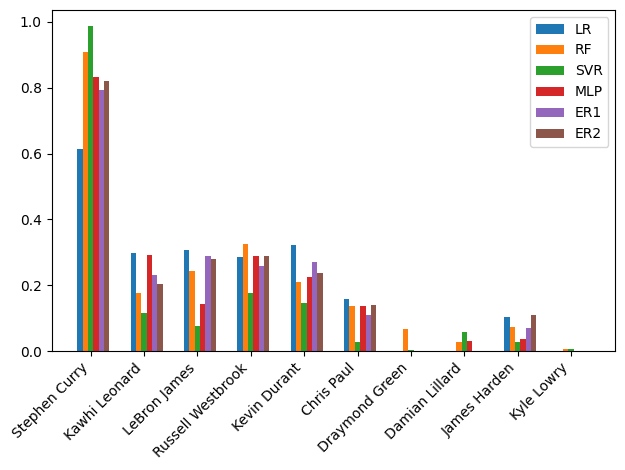

In [82]:
index = np.arange(len(names))
bar_width = 0.1
plt.bar(index, preds_2016[0], width=bar_width, label='LR')
plt.bar(index + bar_width, preds_2016[1], width=bar_width, label='RF')
plt.bar(index + bar_width*2, preds_2016[2], width=bar_width, label='SVR')
plt.bar(index + bar_width*3, preds_2016[3], width=bar_width, label='MLP')
plt.bar(index + bar_width*4, preds_2016[4], width=bar_width, label='ER1')
plt.bar(index + bar_width*5, preds_2016[5], width=bar_width, label='ER2')

plt.xticks(index + 2*bar_width, names, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.savefig('assets/images/mvp-race-2016.png')
plt.show()